In [1]:
# Lora on MNIST: https://github.com/sunildkumar/lora_from_scratch/blob/main/lora_on_mnist.ipynb

In [2]:
import lightning as L  # lightning是一个高层次的深度学习框架，建立在pytorch之上，用于简化和加速模型的开发和训练过程。
from lightning.pytorch.loggers import CSVLogger  # 用于将训练日志记录到csv文件中，便于之后的分析和可视化。
from lightning.pytorch.callbacks import LearningRateFinder  # 通过在training过程中调整学习率lr来找到最优的学习率，以提升模型性能
from lightning.pytorch.callbacks.early_stopping import EarlyStopping  # 用于在validation loss不再改善时提前停止，防止模型过拟合。

from pytorch_lightning import Callback # 用于实现自定义的回调函数，在training过程中的特定时间点执行特定的操作，比如记录日志、保存model、调整lr。

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F  # 包含常用的NN函数
from torch.utils.data import DataLoader, random_split  # DataLoader用于批量加载数据；random_split用于随机划分训练集和验证集
from torch.utils.data.sampler import SubsetRandomSampler  # 用于从数据集中随机采样子集subset

import torchvision  # torch计算机视觉库，提供常用的数据集和变换操作
from torchvision.datasets import MNIST  # 手写数字数据集
from torchvision import transforms  # 包含图像变换操作，如归一化normalization、数据增强。

from torchmetrics import Accuracy

import pandas as pd
import seaborn as sn  # 基于matplotlib的数据可视化库
import math
import matplotlib.pyplot as plt  # 创建图表和可视化数据

# set precison to what lightning suggests for this gpu
torch.set_float32_matmul_precision('high')  # 设置在gpu上进行浮点数矩阵乘法的精度为高精度模型，提高数值稳定性和计算精度
# make results reproducible
L.seed_everything(42)

Seed set to 42


42

In [4]:
# reserved for constants
PATH_DATASETS = 'dataset/'

## MLP Network

In [5]:
# Train a MLP on the first half of MNIST
class LitMNST(L.LightningModule):
    def __init__(self, data_dir=PATH_DATASETS, hidden_size=64, lr=2e-4):
        super().__init__()
        
        # Set our init args as class attributes
        self.data_dir = data_dir
        self.hidden_size = hidden_size
        self.lr = lr
        
        # Hardcode some dataset specific attributes
        self.class_space = [0,1,2,3,4]
        self.min_class = min(self.class_space)
        self.num_classes = len(self.class_space)
        self.dims = (1, 28, 28)  # the shape of an example (C, Width, Hight)
        channels, width, height = self.dims
        
        self.transform = transforms.Compose(  # transforms用于对图像数据进行预处理，将原始图像数据转换为适合DL模型输入的格式；
            [                                 # Compose用于将多个变换操作组合在一起。
                transforms.ToTensor(),        # 将图像numpy数组转换为torch tensor
                transforms.Normalize((0.1307,), (0.3081,)),  # 对tensor进行归一化，两个参数表示：均值mean、std。
            ]
        )
        self.batch_size = 1024
        
        # Define layers for model
        self.l1 = nn.Linear(channels * width * height, hidden_size)
        self.l2 = nn.Linear(hidden_size, hidden_size)
        self.l3 = nn.Linear(hidden_size, self.num_classes)
        
        self.dropout = nn.Dropout(0.1)
        self.relu = nn.ReLU()
        
        # Define metrics: 用于计算多类别accuracy；每次更新用update(preds, target)
        self.val_accuracy = Accuracy(task='multiclass', num_classes=self.num_classes) 
        self.test_accuracy = Accuracy(task='multiclass', num_classes=self.num_classes)
    
    def forward(self, x):  # x.shape = (batch_size, channels, width, height)
        # preprocessing
        x = torch.flatten(x, 1)  # 将tensor从第1维开始展平,start_dim=1
        
        # layer 1: (input_size, hidden_size)
        x = self.l1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        # layer 2: (hidden_size, hidden_size)
        x = self.l2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        # layer 3: (hidden_size, self.num_classes)
        x = self.l3(x)
        
        '''其softmax值不变。==》减去最大的元素，保证最大值为e0=1，因为在0～1之间时，浮点数的精度是最大的。'''
        '''归一化处理 Normalization：用于标准化网络层输出的技术，激活函数activation在它后面，最后是dropout函数。'''
        # notic that we return the log probabilities here as that what nll loss expects in the training step
        return F.log_softmax(x, dim=1)  # 用于计算tensor在dim=1上的log softmax
    
    def common_step(self, batch, batch_idx):  # common_step是DL中常见的函数，batch是当前批次数据；batch_idx是当前批次index
        # define operations all of {train, val, test} will take in each iteration
        x, y = batch  # 提取input和label
        # rescale y to be 0 indexed if necessary (like when we start using mnist 5-9)
        if self.min_class != 0:  # 将second half of MNIST dataset的label转换成从0开始!!!
            y = y - self.min_class  # [5,6,7,8,9] -> [0,1,2,3,4]
        logits = self(x)  # 调用forward()
        loss = F.nll_loss(logits, y)  # 负对数似然损失(Negative Log Likelihood Loss),常用于分类任务，通常与torch.nn.LogSoftmax一起使用。
        return x, y, logits, loss
    
    def training_step(self, batch, batch_idx):  # lightning中单个training step，每个batch数据都会调用这个方法。
        _, _, _, loss = self.common_step(batch, batch_idx)
        self.log("train_loss", loss, batch_size=self.batch_size)  # batch_size=1024; self.log是lightning提供的方法，用于记录指标，便于监控和可视化。
        return loss

    def validation_step(self, batch, batch_idx):
        x, y, logits, loss = self.common_step(batch, batch_idx)
        preds = torch.argmax(logits, dim=1)  # 沿指定维度dim=1返回最大值的index
        self.val_accuracy.update(preds, y)  # 更新度量器状态
        self.log("val_loss", loss, prog_bar=True)  # prog_bar参数，用于指定是否嫁给你日志记录现实在训练进度条progress bar上。
        self.log("val_acc", self.val_accuracy, prog_bar=True)
    
    def test_step(self, batch, batch_idx):
        x, y, logits, loss = self.common_step(batch, batch_idx)
        preds = torch.argmax(logits, dim=1)  # tensor dim=1，返回最大值索引index
        self.test_accuracy.update(preds, y)
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", self.test_accuracy, prog_bar=True)
    
    def configure_optimizers(self):
        # we'll use adamw to match the paper
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr)  # lr=2e-4
        return optimizer
    
    # the rest of the class is helper functions for configuration data/dataloader building
    @staticmethod
    def get_indices(dataset, class_space):  # 从给定数据集中帅选出属于特定类别集合的sample indices。dataset是torch.Dataset或其子集Subset;
        if isinstance(dataset, torch.utils.data.dataset.Subset):
            # dataset.indices获取子集中的索引，并从原始数据集中提取对应的targets.
            targets = torch.tensor([dataset.dataset.targets[i] for i in dataset.indices])
        else:
            targets = dataset.targets
        # 初始化索引index列表
        indices = []
        for i in range(len(targets)):
            if targets[i] in class_space:
                indices.append(i)
        return indices  # 返回符合条件的样本索引
    
    def prepare_data(self):  # torch lightning中，数据加载和准备通常在prepare_data中完成。
        # download data
        MNIST(self.data_dir, train=True, download=True)  # root=表示数据存储路径，train=True表示下载训练集，download=True表示如果数据不存在，是否下载。
        MNIST(self.data_dir, train=False, download=True)  # train=False表示下载测试集
    
    def setup(self, stage=None):  # lightning setup方法用于设置和准备数据集 during traing/val/test dataloader。
        # stage='fit' during training datloader.
        if stage == 'fit' or stage is None:
            mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)  # 下载MNIST训练数据集
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])  # 划分数据集，training + val
            
        # Assign test dataset during test dataloader
        if stage == 'test' or stage is None:
            self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)  # 下载MNST test dataset
    
    def create_dataloader(self, dataset):
        idx = self.get_indices(dataset, self.class_space)  # 获取label空间对应的原始数据index
        # Note - this necessarily shuffles the data due to the sampler we are using
        # dataloader自动将数据集分成batched批次数据，每个batch包含batch_size个样本；随机采样random sampler; num_workers多线程
        loader = DataLoader(dataset, batch_size=self.batch_size, sampler=SubsetRandomSampler(idx), num_workers=16)
        return loader
    
    def train_dataloader(self):
        return self.create_dataloader(self.mnist_train)
    
    def val_dataloader(self):
        return self.create_dataloader(self.mnist_val)
    
    def test_dataloader(self):
        return self.create_dataloader(self.mnist_test)

## train model

In [42]:
model = LitMNST()
trainer = L.Trainer(  # Trainer是lightning中管理和执行训练的核心组件
    accelerator='auto',  # 加速器，自动选择合适的加速器 (gpu or TPU)
    devices=1,           # 指定使用的设备数量
    max_epochs=10,       # 最大训练轮数epochs
    logger=CSVLogger(save_dir='logs/')  # 日志记录器，CSVLogger记录日志到指定路径
)
trainer.fit(model)  # fit方法启动训练过程，model是继承自LightingModule的类实例

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | l1            | Linear             | 50.2 K | train
1 | l2            | Linear             | 4.2 K  | train
2 | l3            | Linear             | 325    | train
3 | dropout       | Dropout            | 0      | train
4 | relu          | ReLU               | 0      | train
5 | val_accuracy  | MulticlassAccuracy | 0      | train
6 | test_accuracy | MulticlassAccuracy | 0      | train
-------------------------------------------------------------
54.7 K    Trainable params
0         Non-trainable params
54.7 K    Total params
0.219     Total estimated model params size (MB)


Sanity Checking: |                                                                               | 0/? [00:00<…

D:\Anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:419: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
D:\Anaconda3\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (28) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "D:\Anaconda3\Lib\multiprocessing\queues.py", line 239, in _feed
Exception ignored in: <function _ConnectionBase.__del__ at 0x000002447FD14900>
Traceback (most recent call last):
  File "D:\Anaconda3\Lib\multiprocessing\connection.py", line 133, in __del__
    self._close()
  File "D:\Anaconda3\Lib\multiprocessing\connection.py", line 282, in _close
    _CloseHandle(self._handle)
OSError: [WinError 6] 句柄无效。
    reader_close()
  File "D:\Anaconda3\Lib\multiprocessing\connection.py", line 178, in close
    self._close()
  File "D:\Anaconda3\Lib\multiprocessing\connection.py", line 282, in _close
    _CloseHandle(self._handle)
OSError: [WinError 6] 句柄无效。

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda3\Lib\threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "D:\Anaconda3\Lib\threading.py", line 982, in run
    self._t

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.


### metrics and pictures

,train_loss,val_acc,val_loss
epoch,,,
0,NaN,0.853496,1.008824
1,0.623317,NaN,NaN
1,NaN,0.914768,0.463142
2,NaN,0.932050,0.253978
3,0.201776,NaN,NaN


D:\Anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


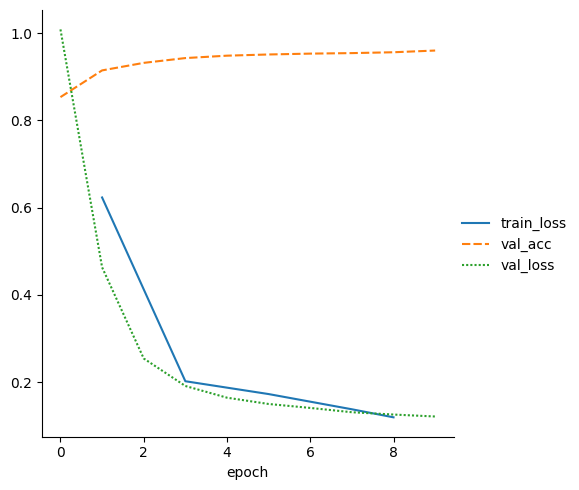

In [43]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics['step']
metrics.set_index('epoch', inplace=True)  # 将epoch设置为索引列，并替换inplace原有的索引列
# axis=1表示沿着列方法进行drop删除包含nan的列; how=all表示整列是nan时才删除该列；head表示展示前5行;display是jupyter展示数据函数
display(metrics.dropna(axis=1, how='all').head())
sn.relplot(data=metrics, kind='line')  # seaborn.replot创建一个关系图，显示数据变量之间的关系趋势，metircs是dataframe数据，line表示折线图

### test model

In [44]:
# as expected our model performs well
trainer.test()
'''
    用于在训练完后对模型进行test，
    1) 定义test dataloader，在setup方法中设置stage=test，确保trainer.test()调用时加载正确数据集。
    2) 调用trainer.test()来出发测试过程
        trainer = Trainer(max_epochs=10, logger=...)
        trainer.fit(model, train_dataloader, val_dataloader)
        trainer.test(test_dataloaders=test_dataloader)
'''

D:\Anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at logs/lightning_logs\version_0\checkpoints\epoch=9-step=280.ckpt
Loaded model weights from the checkpoint at logs/lightning_logs\version_0\checkpoints\epoch=9-step=280.ckpt
D:\Anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker nu

Testing: |                                                                                       | 0/? [00:00<…

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9745086431503296     │
│         test_loss         │    0.08371803909540176    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.08371803909540176, 'test_acc': 0.9745086431503296}]

### save model

In [46]:
# save model weights so we can finetune them later
trainer.save_checkpoint('results/LoRA02_MNIST/mlp_model.ckpt')
torch.save(model.state_dict(), 'results/LoRA02_MNIST/mlp_model.pt')

## Finetune on second half of MNIST

### model_no_finetuning

In [6]:
# load the model 
# we refer to it as "no training" as we are going to use this initialization to show that the model performs poorly on the second half of mnist (as it wasn't trained on it)
model_loaded_no_finetuning = LitMNST.load_from_checkpoint(checkpoint_path='mlp_model.ckpt')

In [7]:
# set it up to run on the second half of mnist (digits 5,6,7,8,9)
model_loaded_no_finetuning.class_space = [5,6,7,8,9]
model_loaded_no_finetuning.min_class = min(model_loaded_no_finetuning.class_space)

In [8]:
# we will train on the new data exactly one element once 
# (this is so we can access the trainer2.test() function, which allows us to easily evaluate how well our model works on the new data)
model_loaded_no_finetuning.batch_size = 1
trainer_no_tune = L.Trainer(  # 在training过程中，common step函数会把[5,6,7,8,9] -> [0,1,2,3,4]
    accelerator='auto',
    devices=1,
    max_steps=1,  # max_steps用于指定每个epoch中的最大步数，max_steps=1即每个epoch训练步数都要小于1，即不会进行training
    logger=CSVLogger(save_dir='logs/'),
)
trainer_no_tune.fit(model_loaded_no_finetuning)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | l1            | Linear             | 50.2 K | train
1 | l2            | Linear             | 4.2 K  | train
2 | l3            | Linear             | 325    | train
3 | dropout       | Dropout            | 0      | train
4 | relu          | ReLU               | 0      | train
5 | val_accuracy  | MulticlassAccuracy | 0      | train
6 | test_accuracy | MulticlassAccuracy | 0      | train
-------------------------------------------------------------
54.7 K    Trainable params
0         Non-trainable params
54.7 K    Total params
0.219     Total estimated model params size (MB)


Sanity Checking: |                                                                               | 0/? [00:00<…

D:\Anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
D:\Anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:419: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
D:\Anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:419: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1` reached.


In [9]:
# we can see our model performs extremely poorly on the new data that it hasn't seen, which is unsuprising.
model_loaded_no_finetuning.test()

D:\Anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at logs/lightning_logs\version_1\checkpoints\epoch=0-step=1.ckpt
Loaded model weights from the checkpoint at logs/lightning_logs\version_1\checkpoints\epoch=0-step=1.ckpt
D:\Anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:419: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing: |                                                                                       | 0/? [00:00<…

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.33861345052719116    │
│         test_loss         │     2.882897138595581     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 2.882897138595581, 'test_acc': 0.33861345052719116}]

### model_finetuning

In [12]:
# now finetune e2e on the new data
model_finetuning = LitMNST.load_from_checkpoint(checkpoint_path='mlp_model.ckpt')
# set it up to run on the second half of mnist (digits 5,6,7,8,9)
model_finetuning.class_space = [5,6,7,8,9]
model_finetuning.min_class = min(model_finetuning.class_space)

trainer = L.Trainer(
    accelerator='auto',
    devices=1,
    max_epochs=10,
    logger=CSVLogger(save_dir='logs/'),
)
trainer.fit(model_finetuning)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | l1            | Linear             | 50.2 K | train
1 | l2            | Linear             | 4.2 K  | train
2 | l3            | Linear             | 325    | train
3 | dropout       | Dropout            | 0      | train
4 | relu          | ReLU               | 0      | train
5 | val_accuracy  | MulticlassAccuracy | 0      | train
6 | test_accuracy | MulticlassAccuracy | 0      | train
-------------------------------------------------------------
54.7 K    Trainable params
0         Non-trainable params
54.7 K    Total params
0.219     Total estimated model params size (MB)


Sanity Checking: |                                                                               | 0/? [00:00<…

D:\Anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
D:\Anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:419: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
D:\Anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:419: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
D:\Anaconda3\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of 

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.


In [13]:
# unsuprisingly finetuning allows us to perform equally well on the second half of MNIST.
# However this approach would requires us to save the ENTIRE model binary for each dataset we wanted to finetune our initial model on,
# wich doesn't scale well.
trainer.test()

D:\Anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at logs/lightning_logs\version_2\checkpoints\epoch=9-step=280.ckpt
Loaded model weights from the checkpoint at logs/lightning_logs\version_2\checkpoints\epoch=9-step=280.ckpt
D:\Anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:419: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing: |                                                                                       | 0/? [00:00<…

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9838489890098572     │
│         test_loss         │   0.052110206335783005    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.052110206335783005, 'test_acc': 0.9838489890098572}]

## model_lora

In [29]:
class LitMNISTLoRA(L.LightningModule):
    def __init__(self, data_dir=PATH_DATASETS, hidden_size=64, lr=2e-4, lora_rank=8):
        super().__init__()
        
        # Set our init args as class attributes
        self.data_dir = data_dir
        self.hidden_size = hidden_size
        self.lr = lr
        
        # Hardcode some dataset specific attributes
        self.class_space = [0,1,2,3,4]
        self.min_class = min(self.class_space)
        self.num_classes = len(self.class_space)
        self.dims = (1, 28, 28)  # the shape of an example (C, W, H)
        channels, width, height = self.dims
        
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081)),
            ]
        )
        self.batch_size = 64
        
        # Define layers for model
        self.l1 = nn.Linear(channels * width * height, hidden_size)
        self.l2 = nn.Linear(hidden_size, hidden_size)
        self.l3 = nn.Linear(hidden_size, self.num_classes)
        
        self.dropout = nn.Dropout(0.1)
        self.relu = nn.ReLU()
        
        # Define lora hyperparameters
        self.lora_rank = lora_rank  # the rank 'r' for the low-rank adaptation
        self.lora_alpha = 1  # lora scaling factor 缩放因子
        
        # Lora layer 1
        self.l1_lora_A = nn.Parameter(torch.empty(channels * width * height, self.lora_rank))
        self.l1_lora_B = nn.Parameter(torch.empty(self.lora_rank, hidden_size))
        
        # Lora layer 2
        self.l2_lora_A = nn.Parameter(torch.empty(hidden_size, self.lora_rank))
        self.l2_lora_B = nn.Parameter(torch.empty(self.lora_rank, hidden_size))
        
        # Lora layer 3
        self.l3_lora_A = nn.Parameter(torch.empty(hidden_size, self.lora_rank))
        self.l3_lora_B = nn.Parameter(torch.empty(self.lora_rank, self.num_classes))
        
        # Define initialization for lora layers (this ensures that the model behavior is identitial to the original model)
        # torch对lora 参数进行初始化
        for n,p in self.named_parameters():  # named_parameters方法遍历模型self中所有参数，n是参数名，p是参数值。
            if 'lora' in n:
                if n[-1] == 'A':
                    nn.init.kaiming_uniform_(p, a=math.sqrt(5))  # 从均匀分布中初始化tensor p，a值是激活函数的负斜率
                elif n[-1] == 'B':
                    nn.init.zeros_(p)
        
        # freeze non lora weights
        for n,p in self.named_parameters():
            if 'lora' not in n:
                p.requires_grad = False
        
        # Define metrics
        self.val_accuracy = Accuracy(task='multiclass', num_classes=self.num_classes)
        self.test_accuracy = Accuracy(task='multiclass', num_classes=self.num_classes)
    
    def lora_linear(self, x, layer, lora_A, lora_B):
        # does the work of combining outputs from normal layer and lora layer for x
        # notice that h is the sum of two separate operations on x
        h = layer(x)
        h += x@(lora_A @ lora_B)* self.lora_alpha  # h = (w +α*Δw)*x
        return h
    
    def forward(self, x):
        # preprocessing
        x = torch.flatten(x, 1)
        
        # layer 1 (input_size, hidden_size)
        x = self.lora_linear(x, self.l1, self.l1_lora_A, self.l1_lora_B)
        x = self.relu(x)
        x = self.dropout(x)
        
        # layer 2 (hidden_size, hidden_size)
        x = self.lora_linear(x, self.l2, self.l2_lora_A, self.l2_lora_B)
        x = self.relu(x)
        x = self.dropout(x)
        
        # layer 3 (hidden_size, self.num_classes)
        x = self.lora_linear(x, self.l3, self.l3_lora_A, self.l3_lora_B)
        
        # notice that we return the log probabilities  here as that is what nll loss expects in the training step
        return F.log_softmax(x, dim=1)
    
    def common_step(self, batch, batch_idx):
        # define operations of {train, val, test} will take in one place
        x, y = batch
        # rescale y to be 0 indexed if necessary (like when we start using mnist 5-9)
        if self.min_class != 0:
            y = y - self.min_class
        logits = self(x)
        loss = F.nll_loss(logits, y)
        return x, y, logits, loss
    
    def training_step(self, batch, batch_idx):
        _, _, _, loss = self.common_step(batch, batch_idx)
        self.log("train_loss", loss, batch_size=self.batch_size)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y, logits, loss = self.common_step(batch, batch_idx)
        preds = torch.argmax(logits, dim=1)
        self.val_accuracy.update(preds, y)
        self.log('val_loss', loss, prog_bar=False)
        self.log('val_acc', self.val_accuracy, prog_bar=True)
    
    def test_step(self, batch, batch_idx):
        x, y, logits, loss = self.common_step(batch, batch_idx)
        preds = torch.argmax(logits, dim=1)  # 沿dim=1返回tensor最大值的索引index
        self.test_accuracy.update(preds, y)
        self.log('test_loss', loss, prog_bar=True)
        self.log('test_acc', self.test_accuracy, prog_bar=True)
    
    def configure_optimizers(self):
        # we'll use adamw to match the paper
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr)
        # 学习率调度器，ReduceLRonPlateau会在val指标停止改善时降低lr；min表示val loss最小化；patient=10表示10个周期内没有改善就降低lr
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10)
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'val_loss',
                'frequency': 1,
            }
        }  # lightning在训练过程中自动管理优化和调整学习率
    
    # the rest of the class if helper functions for configuration data/dataloader building
    @staticmethod
    def get_indices(dataset, class_space):
        if isinstance(dataset, torch.utils.data.dataset.Subset):
            targets = torch.tensor([dataset.dataset.targets[i] for i in dataset.indices])
        else:
            targets = dataset.targets
        indices = []
        for i in range(len(targets)):
            if targets[i] in class_space:
                indices.append(i)
        return indices
    
    def prepare_data(self):
        # download_data
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)
    
    def setup(self, stage=None):
        # Assign train/bal datasets for use in dataloaders
        if stage == 'fit' or stage is None:
            mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])
        
        # Assign test dataset for use in dataloader
        if stage == 'test' or stage is None:
            self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)
        
    def create_dataloader(self, dataset):
        idx = self.get_indices(dataset, self.class_space)
        # Note - this necessarily shuffles the data due to the sampler we are using
        loader = DataLoader(dataset, batch_size=self.batch_size, sampler=SubsetRandomSampler(idx), num_workers=16)
        return loader
    
    def train_dataloader(self):
        return self.create_dataloader(self.mnist_train)
    
    def val_dataloader(self):
        return self.create_dataloader(self.mnist_val)
    
    def test_dataloader(self):
        return self.create_dataloader(self.mnist_test)

### lora experiment

In [30]:
# try lora finetuning with different lora ranks
def lora_experiment(rank):
    state_dict = torch.load('mlp_model.pt')
    model = LitMNISTLoRA(lora_rank=rank)
    model.load_state_dict(state_dict, strict=False)
    model.class_space = [5,6,7,8,9]
    model.min_class = min(model.class_space)
    
    from lightning.pytorch.callbacks import LearningRateMonitor  # 用于监控和记录学习率变化
    lr_monitor = LearningRateMonitor(logging_interval='step')  # 记录间隔
    
    trainer = L.Trainer(
        accelerator='auto',
        devices=1,
        max_epochs=10,
        callbacks=[lr_monitor, EarlyStopping(monitor='val_loss', mode='min', patience=10)], # 回调函数val metrics，指标值越小min越好
        enable_progress_bar=False,
    )
    trainer.fit(model)
    return trainer.test()[0]['test_acc']  # 返回测试结果列表，第一个字典test results

In [44]:
trainer.test()

D:\Anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at logs/lightning_logs\version_2\checkpoints\epoch=9-step=280.ckpt
Loaded model weights from the checkpoint at logs/lightning_logs\version_2\checkpoints\epoch=9-step=280.ckpt
D:\Anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker nu

Testing: |                                                                                       | 0/? [00:00<…

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9838489890098572     │
│         test_loss         │   0.052110206335783005    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.052110206335783005, 'test_acc': 0.9838489890098572}]

In [31]:
results = {}
for rank in [1,2,4,8,16,32,64]:
    result = lora_experiment(rank)
    results[rank] = result
    print(result)
print(results)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | l1            | Linear             | 50.2 K | train
1 | l2            | Linear             | 4.2 K  | train
2 | l3            | Linear             | 325    | train
3 | dropout       | Dropout            | 0      | train
4 | relu          | ReLU               | 0      | train
5 | val_accuracy  | MulticlassAccuracy | 0      | train
6 | test_accuracy | MulticlassAccuracy | 0      | train
  | other params  | n/a                | 1.0 K  | n/a  
-------------------------------------------------------------
1.0 K     Trainable params
54.7 K    Non-trainable params
55.8 K    Total params
0.223     Total estimated model params size (MB)
D:\Anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:419: Consider setting `persistent_workers=Tr

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7858465313911438     │
│         test_loss         │    0.5735034346580505     │
└───────────────────────────┴───────────────────────────┘

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | l1            | Linear             | 50.2 K | train
1 | l2            | Linear             | 4.2 K  | train
2 | l3            | Linear             | 325    | train
3 | dropout       | Dropout            | 0      | train
4 | relu          | ReLU               | 0      | train
5 | val_accuracy  | MulticlassAccuracy | 0      | train
6 | test_accuracy | MulticlassAccuracy | 0      | train
  | other params  | n/a                | 2.1 K  | n/a  
-------------------------------------------------------------
2.1 K     Trainable params
54.7 K    Non-trainable params
56.8 K    Total params
0.227     Total estimated model params size (MB)


0.7858465313911438


`Trainer.fit` stopped: `max_epochs=10` reached.
Restoring states from the checkpoint path at C:\Users\yysgz\OneDrive - Macquarie University\Desktop\LLM_Prompts\soft_prompt_tuning\lightning_logs\version_3\checkpoints\epoch=9-step=4220.ckpt
Loaded model weights from the checkpoint at C:\Users\yysgz\OneDrive - Macquarie University\Desktop\LLM_Prompts\soft_prompt_tuning\lightning_logs\version_3\checkpoints\epoch=9-step=4220.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8850030899047852     │
│         test_loss         │    0.3334353268146515     │
└───────────────────────────┴───────────────────────────┘

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | l1            | Linear             | 50.2 K | train
1 | l2            | Linear             | 4.2 K  | train
2 | l3            | Linear             | 325    | train
3 | dropout       | Dropout            | 0      | train
4 | relu          | ReLU               | 0      | train
5 | val_accuracy  | MulticlassAccuracy | 0      | train
6 | test_accuracy | MulticlassAccuracy | 0      | train
  | other params  | n/a                | 4.2 K  | n/a  
-------------------------------------------------------------
4.2 K     Trainable params
54.7 K    Non-trainable params
58.9 K    Total params
0.236     Total estimated model params size (MB)


0.8850030899047852


`Trainer.fit` stopped: `max_epochs=10` reached.
Restoring states from the checkpoint path at C:\Users\yysgz\OneDrive - Macquarie University\Desktop\LLM_Prompts\soft_prompt_tuning\lightning_logs\version_4\checkpoints\epoch=9-step=4210.ckpt
Loaded model weights from the checkpoint at C:\Users\yysgz\OneDrive - Macquarie University\Desktop\LLM_Prompts\soft_prompt_tuning\lightning_logs\version_4\checkpoints\epoch=9-step=4210.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9325241446495056     │
│         test_loss         │    0.2095007598400116     │
└───────────────────────────┴───────────────────────────┘

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | l1            | Linear             | 50.2 K | train
1 | l2            | Linear             | 4.2 K  | train
2 | l3            | Linear             | 325    | train
3 | dropout       | Dropout            | 0      | train
4 | relu          | ReLU               | 0      | train
5 | val_accuracy  | MulticlassAccuracy | 0      | train
6 | test_accuracy | MulticlassAccuracy | 0      | train
  | other params  | n/a                | 8.4 K  | n/a  
-------------------------------------------------------------
8.4 K     Trainable params
54.7 K    Non-trainable params
63.1 K    Total params
0.252     Total estimated model params size (MB)


0.9325241446495056


`Trainer.fit` stopped: `max_epochs=10` reached.
Restoring states from the checkpoint path at C:\Users\yysgz\OneDrive - Macquarie University\Desktop\LLM_Prompts\soft_prompt_tuning\lightning_logs\version_5\checkpoints\epoch=9-step=4220.ckpt
Loaded model weights from the checkpoint at C:\Users\yysgz\OneDrive - Macquarie University\Desktop\LLM_Prompts\soft_prompt_tuning\lightning_logs\version_5\checkpoints\epoch=9-step=4220.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9491873979568481     │
│         test_loss         │    0.15515846014022827    │
└───────────────────────────┴───────────────────────────┘

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | l1            | Linear             | 50.2 K | train
1 | l2            | Linear             | 4.2 K  | train
2 | l3            | Linear             | 325    | train
3 | dropout       | Dropout            | 0      | train
4 | relu          | ReLU               | 0      | train
5 | val_accuracy  | MulticlassAccuracy | 0      | train
6 | test_accuracy | MulticlassAccuracy | 0      | train
  | other params  | n/a                | 16.7 K | n/a  
-------------------------------------------------------------
16.7 K    Trainable params
54.7 K    Non-trainable params
71.4 K    Total params
0.286     Total estimated model params size (MB)


0.9491873979568481


`Trainer.fit` stopped: `max_epochs=10` reached.
Restoring states from the checkpoint path at C:\Users\yysgz\OneDrive - Macquarie University\Desktop\LLM_Prompts\soft_prompt_tuning\lightning_logs\version_6\checkpoints\epoch=9-step=4210.ckpt
Loaded model weights from the checkpoint at C:\Users\yysgz\OneDrive - Macquarie University\Desktop\LLM_Prompts\soft_prompt_tuning\lightning_logs\version_6\checkpoints\epoch=9-step=4210.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9539189338684082     │
│         test_loss         │    0.14538365602493286    │
└───────────────────────────┴───────────────────────────┘

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | l1            | Linear             | 50.2 K | train
1 | l2            | Linear             | 4.2 K  | train
2 | l3            | Linear             | 325    | train
3 | dropout       | Dropout            | 0      | train
4 | relu          | ReLU               | 0      | train
5 | val_accuracy  | MulticlassAccuracy | 0      | train
6 | test_accuracy | MulticlassAccuracy | 0      | train
  | other params  | n/a                | 33.4 K | n/a  
-------------------------------------------------------------
33.4 K    Trainable params
54.7 K    Non-trainable params
88.2 K    Total params
0.353     Total estimated model params size (MB)


0.9539189338684082


`Trainer.fit` stopped: `max_epochs=10` reached.
Restoring states from the checkpoint path at C:\Users\yysgz\OneDrive - Macquarie University\Desktop\LLM_Prompts\soft_prompt_tuning\lightning_logs\version_7\checkpoints\epoch=9-step=4210.ckpt
Loaded model weights from the checkpoint at C:\Users\yysgz\OneDrive - Macquarie University\Desktop\LLM_Prompts\soft_prompt_tuning\lightning_logs\version_7\checkpoints\epoch=9-step=4210.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9619419574737549     │
│         test_loss         │    0.11542871594429016    │
└───────────────────────────┴───────────────────────────┘

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | l1            | Linear             | 50.2 K | train
1 | l2            | Linear             | 4.2 K  | train
2 | l3            | Linear             | 325    | train
3 | dropout       | Dropout            | 0      | train
4 | relu          | ReLU               | 0      | train
5 | val_accuracy  | MulticlassAccuracy | 0      | train
6 | test_accuracy | MulticlassAccuracy | 0      | train
  | other params  | n/a                | 66.9 K | n/a  
-------------------------------------------------------------
66.9 K    Trainable params
54.7 K    Non-trainable params
121 K     Total params
0.486     Total estimated model params size (MB)


0.9619419574737549


`Trainer.fit` stopped: `max_epochs=10` reached.
Restoring states from the checkpoint path at C:\Users\yysgz\OneDrive - Macquarie University\Desktop\LLM_Prompts\soft_prompt_tuning\lightning_logs\version_8\checkpoints\epoch=9-step=4220.ckpt
Loaded model weights from the checkpoint at C:\Users\yysgz\OneDrive - Macquarie University\Desktop\LLM_Prompts\soft_prompt_tuning\lightning_logs\version_8\checkpoints\epoch=9-step=4220.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9724336266517639     │
│         test_loss         │    0.08334653824567795    │
└───────────────────────────┴───────────────────────────┘

0.9724336266517639
{1: 0.7858465313911438, 2: 0.8850030899047852, 4: 0.9325241446495056, 8: 0.9491873979568481, 16: 0.9539189338684082, 32: 0.9619419574737549, 64: 0.9724336266517639}


In [36]:
results

{1: 0.7858465313911438,
 2: 0.8850030899047852,
 4: 0.9325241446495056,
 8: 0.9491873979568481,
 16: 0.9539189338684082,
 32: 0.9619419574737549,
 64: 0.9724336266517639}

### lora pictures

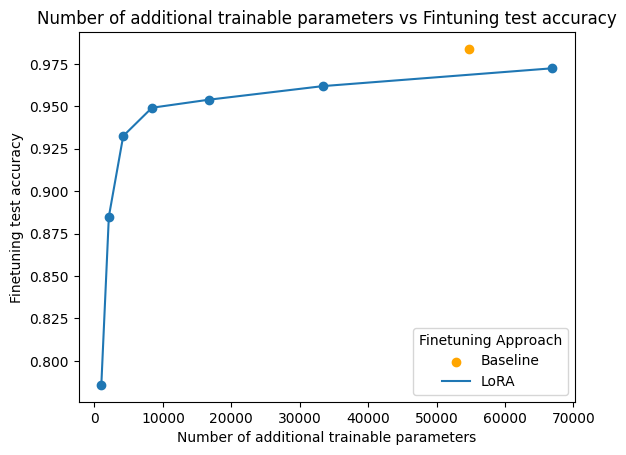

In [47]:
fig, ax = plt.subplots()  # 创建一个图形对象fig和一个坐标轴对象ax
baseline_num_parameters = 54700
baseline_accuracy = 0.9838489890098572
ax.scatter(baseline_num_parameters, baseline_accuracy, c='orange')  # ax.scatter绘制一个散点，scatter是分散的意思

lora_rank = [1,2,4,8,16,32,64]
lora_num_parameters = [1000, 2100, 4200, 8400, 16700, 33400, 66900]
lora_accuracy = [0.7858465313911438, 0.8850030899047852, 0.9325241446495056, 0.9491873979568481, 0.9539189338684082, 
                 0.9619419574737549, 0.9724336266517639]
ax.plot(lora_num_parameters, lora_accuracy)  # ax.plot绘制折线图
plt.scatter(lora_num_parameters, lora_accuracy)  # plt.scatter绘制散点图

legend1 = ax.legend(['Baseline', 'LoRA'], loc='lower right', title='Finetuning Approach')  # 添加图例和图例标题

ax.set_xlabel('Number of additional trainable parameters')  # 设置x轴标题
ax.set_ylabel('Finetuning test accuracy')                   # 设置y轴标题
ax.set_title('Number of additional trainable parameters vs Fintuning test accuracy')
plt.savefig('results/LoRA02_MNIST/parameter_vs_accuracy.png')
plt.show()


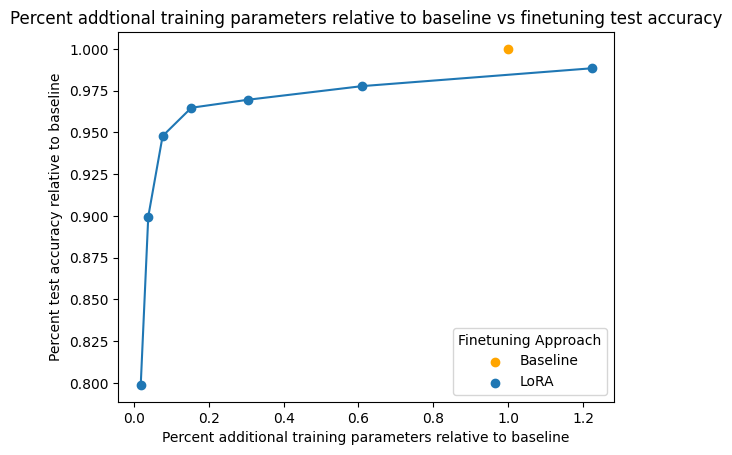

In [42]:
fig, ax = plt.subplots()

ax.scatter(baseline_num_parameters/baseline_num_parameters, baseline_accuracy/baseline_accuracy, c='orange')
lora_parameters_relative_to_baseline = [i/baseline_num_parameters for i in lora_num_parameters]
lora_accuracy_relative_to_baseline = [i/baseline_accuracy for i in lora_accuracy]
ax.scatter(lora_parameters_relative_to_baseline, lora_accuracy_relative_to_baseline)
ax.plot(lora_parameters_relative_to_baseline, lora_accuracy_relative_to_baseline)

legend1 = ax.legend(['Baseline', 'LoRA'], loc='lower right', title='Finetuning Approach')

ax.set_xlabel('Percent additional training parameters relative to baseline')
ax.set_ylabel('Percent test accuracy relative to baseline')
ax.set_title('Percent addtional training parameters relative to baseline vs finetuning test accuracy')
plt.savefig('results/LoRA02_MNIST/real_parameters_vs_rel_accuracy.png', bbox_inches='tight')
plt.show()